https://learn.qiskit.org/v1/course/ch-algorithms/defining-quantum-circuits

In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer, transpile, assemble, converters
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.visualization import plot_histogram

# importing Qiskit
from qiskit.quantum_info import SparsePauliOp
from qiskit.opflow import I, X, Y, Z, H, CX, Zero, ListOp, PauliExpectation, PauliTrotterEvolution, CircuitSampler, MatrixEvolution, Suzuki, PauliSumOp
from qiskit.circuit import Parameter

from qiskit.quantum_info.operators import Operator
from qiskit.extensions import UnitaryGate
from qiskit.circuit.add_control import add_control
import qiskit.quantum_info as qi


In [2]:
import numpy as np
import scipy.linalg as la
des = [7/8, 3/8]
n = len(des)
s = np.diag(des)
q, _ = la.qr(np.random.rand(n, n))
A = q.T @ s @ q
eigs_h, vecs_h = np.linalg.eig(A)
RESULTS = []
# print(A)

In [3]:
# noise = np.random.normal(0,0.001,(2,2))/2
# noise = noise + noise.conj().T
# U = la.expm(1j*A)
# # U_noised = la.expm(1j*(A+noise))
# U_noise = la.expm(1j*(noise.T))
# U_noised = np.dot(U_noise, U)
# print(U)
# print(U_noised)
# print(np.dot(U, U_noise))

In [80]:
from sklearn.preprocessing import normalize
ERROR = 0.1
def add_noise_to_gate(U):
    noise = np.random.normal(0, ERROR, U.shape)/2
    noise = noise + noise.conj().T
    U_noise = la.expm(1j*(noise.T))
    U = np.dot(U_noise, U)
    return U

In [81]:
U = la.expm(1j*A)
eigs_u, vecs_u = np.linalg.eig(U)


In [82]:
n_of_qubs = 10
qpe = QuantumCircuit(n_of_qubs+1, n_of_qubs)
qpe.initialize(vecs_u[1], n_of_qubs)

QiskitError: 'StatePreparation parameter vector has 4 elements, therefore expects 2 qubits. However, 1 were provided.'

In [83]:
# for qubit in range(n_of_qubs):
import time
qpe_clear = QuantumCircuit(n_of_qubs+1)
for qubit in range(n_of_qubs):
    qpe_clear.h(qubit)
    
backend = Aer.get_backend('unitary_simulator')
job = execute(qpe_clear, backend)
result = job.result()
op = result.get_unitary(qpe_clear).data
op = add_noise_to_gate(op)
U_h = UnitaryGate(op)

qpe.append(U_h, range(n_of_qubs+1))    
# print(qpe)

In [84]:
gate = UnitaryGate(U).control(1)
repetitions = 1
qpe_clear = QuantumCircuit(n_of_qubs+1)
for i in range(0, n_of_qubs):
    for _ in range(repetitions):
        qpe_clear.append(gate,[i, n_of_qubs])
    repetitions *= 2
    
backend = Aer.get_backend('unitary_simulator')
job = execute(qpe_clear, backend)
result = job.result()
op = result.get_unitary(qpe_clear).data
op = add_noise_to_gate(op)
U_h = UnitaryGate(op)

qpe.append(U_h, range(n_of_qubs+1))

In [85]:
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-math.pi/float(2**(j-m)), m, j)
        qc.h(j)

In [86]:
qpe.barrier()
# Apply inverse QFT
qpe_clear = QuantumCircuit(n_of_qubs+1)
qft_dagger(qpe_clear, n_of_qubs)
backend = Aer.get_backend('unitary_simulator')
job = execute(qpe_clear, backend)
result = job.result()
op = result.get_unitary(qpe_clear).data
op = add_noise_to_gate(op)
U_h = UnitaryGate(op)
qpe.append(U_h, range(n_of_qubs+1))
# Measure
qpe.barrier()
for n in range(n_of_qubs):
    qpe.measure(n,n)

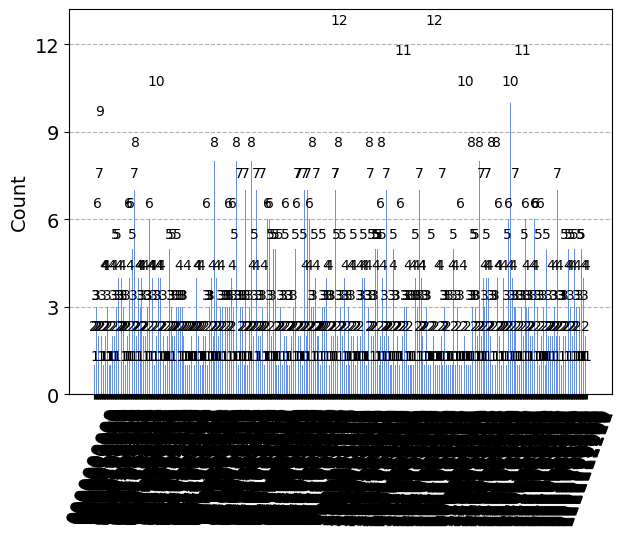

In [87]:
aer_sim = Aer.get_backend('aer_simulator')
shots = 2048
t_qpe = transpile(qpe, aer_sim)
qobj = assemble(t_qpe, shots=shots)
results = aer_sim.run(qobj).result()
answer = results.get_counts()
answer_to_plot = answer.copy()
answer = sorted(answer.items(), key=lambda x:x[1])
new_ans = []
for pair in answer:
    new_ans.append((int(pair[0],2), pair[1]))
answer = new_ans
plot_histogram(answer_to_plot)

In [88]:
# qpe.draw()

In [89]:
print(answer)

[(569, 1), (711, 1), (839, 1), (418, 1), (389, 1), (784, 1), (30, 1), (979, 1), (716, 1), (253, 1), (722, 1), (707, 1), (64, 1), (719, 1), (849, 1), (767, 1), (524, 1), (1015, 1), (768, 1), (996, 1), (922, 1), (118, 1), (743, 1), (598, 1), (951, 1), (340, 1), (362, 1), (533, 1), (527, 1), (1013, 1), (796, 1), (268, 1), (207, 1), (704, 1), (370, 1), (748, 1), (848, 1), (20, 1), (178, 1), (383, 1), (515, 1), (259, 1), (256, 1), (327, 1), (78, 1), (756, 1), (402, 1), (780, 1), (154, 1), (940, 1), (786, 1), (366, 1), (549, 1), (318, 1), (47, 1), (585, 1), (596, 1), (261, 1), (145, 1), (661, 1), (460, 1), (935, 1), (928, 1), (697, 1), (324, 1), (245, 1), (427, 1), (958, 1), (286, 1), (915, 1), (147, 1), (397, 1), (70, 1), (124, 1), (755, 1), (201, 1), (192, 1), (130, 1), (17, 1), (559, 1), (739, 1), (1007, 1), (690, 1), (718, 1), (850, 1), (785, 1), (658, 1), (869, 1), (314, 1), (702, 1), (706, 1), (884, 1), (426, 1), (607, 1), (564, 1), (42, 1), (225, 1), (1011, 1), (875, 1), (986, 1), (78

In [90]:
import scipy.linalg as la
# print(la.expm(1j*4*np.pi*0/shots))
print(la.expm(1j*2*np.pi*61/(2**n_of_qubs)))

[[0.93076696+0.365613j]]


In [91]:
eigs_u

array([0.64099686+0.7675435j , 0.93050762+0.36627253j])

# Answers sorting and plotting

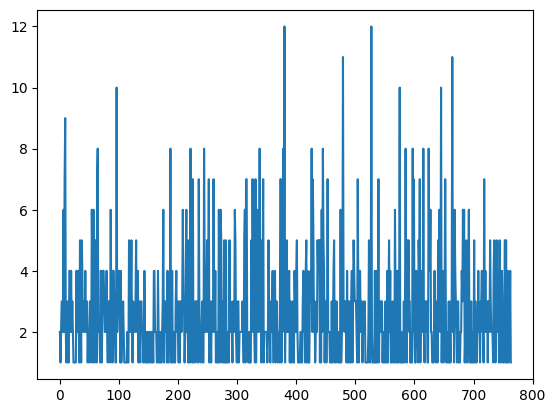

In [92]:
answer_copy = answer.copy()
answer_copy.sort(key=lambda x: x[0])
y = [val[1] for val in answer_copy]
x = [val[0] for val in answer_copy]
RESULTS.append((ERROR, x, y))
plt.plot(y)

In [93]:
# RESULTS.append((ERROR, histogram))

In [94]:
len(RESULTS)

5

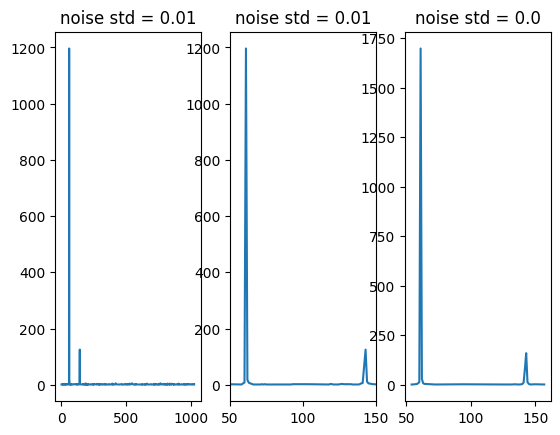

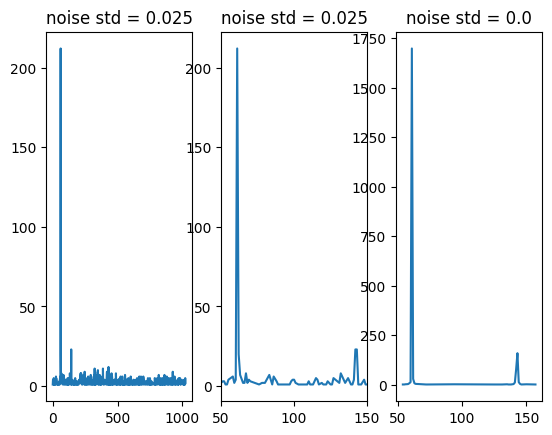

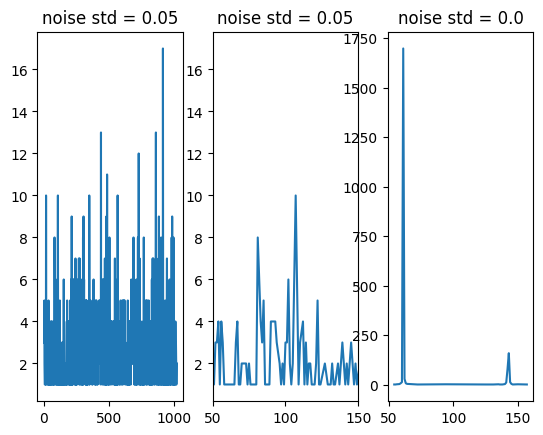

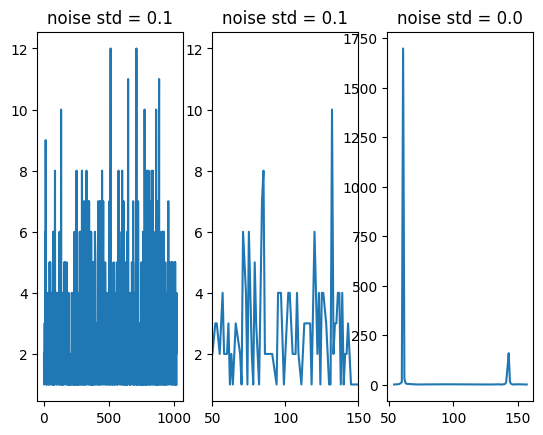

In [95]:
for tupple in RESULTS[1:]:
    plt.subplot(1, 3, 1)
    plt.plot(tupple[1], tupple[2])
    plt.title(f'noise std = {tupple[0]}')
    plt.subplot(1, 3, 2)
    plt.plot(tupple[1], tupple[2])
    plt.title(f'noise std = {tupple[0]}')
    plt.xlim(50, 150)
    plt.subplot(1, 3, 3)
    plt.plot(RESULTS[0][1],RESULTS[0][2])
    plt.title(f'noise std = {RESULTS[0][0]}')
    plt.show()

In [46]:
# plt.plot(tupple[1], tupple[2])
# plt.title(f'noise std = {tupple[0]}')
# plt.plot(RESULTS[0][1], RESULTS[0][2])
# plt.title(f'noise std = {RESULTS[0][0]}')
# plt.show()

# In JSON format

In [100]:
result = {}
for tupple in RESULTS:
    result[tupple[0]] = {
        'x': tupple[1],
        'y': tupple[2]
    }

In [101]:
import json

# Serialize data into file:
json.dump( result, open( "2.json", 'w' ) )